# TabPFN 数据探索分析（EDA）

该 Notebook 针对 Hull Tactical Market Prediction 数据集，对训练/测试集做系统的统计分析、相关性、缺失检测、PCA 以及关键特征筛选，并辅以可视化结果。

## 目录
1. 环境与数据载入
2. 数据规模 & 预览
3. 描述性统计
4. 缺失值与数据质量
5. 相关性与可视化
6. PCA 及解释方差
7. 关键特征汇总

In [3]:

from __future__ import annotations
import json
from pathlib import Path
from typing import List

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

sns.set_theme(style="whitegrid")
plt.rcParams["figure.figsize"] = (12, 6)
pd.set_option("display.max_rows", 100)
pd.set_option("display.max_columns", 120)

TARGET_COL = "forward_returns"
DATA_ROOT = Path("../input/hull-tactical-market-prediction").resolve()
if not DATA_ROOT.exists():
    raise FileNotFoundError(f"Data root not found: {DATA_ROOT}")
train_path = DATA_ROOT / "train.csv"
test_path = DATA_ROOT / "test.csv"
train_df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)

# 为了在可视化和 PCA 时控制成本，最多使用 200k 行样本
SAMPLE_ROWS = 200_000
if len(train_df) > SAMPLE_ROWS:
    eda_df = train_df.sample(SAMPLE_ROWS, random_state=42)
    print(f"[INFO] Using sampled {len(eda_df)} rows for heavy EDA (from {len(train_df)} total).")
else:
    eda_df = train_df.copy()
    print(f"[INFO] Using full training set ({len(eda_df)} rows) for EDA.")

print("Training set shape:", train_df.shape)
print("Test set shape:", test_df.shape)
train_df.head()


[INFO] Using full training set (8990 rows) for EDA.
Training set shape: (8990, 98)
Test set shape: (10, 99)


,date_id,D1,D2,D3,D4,D5,D6,D7,D8,D9,E1,E10,E11,E12,E13,E14,E15,E16,E17,E18,E19,E2,E20,E3,E4,E5,E6,E7,E8,E9,I1,I2,I3,I4,I5,I6,I7,I8,I9,M1,M10,M11,M12,M13,M14,M15,M16,M17,M18,M2,M3,M4,M5,M6,M7,M8,M9,P1,P10,P11,P12,P13,P2,P3,P4,P5,P6,P7,P8,P9,S1,S10,S11,S12,S2,S3,S4,S5,S6,S7,S8,S9,V1,V10,V11,V12,V13,V2,V3,V4,V5,V6,V7,V8,V9,forward_returns,risk_free_rate,market_forward_excess_returns
0,0,0,0,0,1,1,0,0,0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.002421,0.000301,-0.003038
1,1,0,0,0,1,1,0,0,0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.008495,0.000303,-0.009114
2,2,0,0,0,1,0,0,0,0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.009624,0.000301,-0.010243
3,3,0,0,0,1,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.004662,0.000299,0.004046
4,4,0,0,0,1,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.011686,0.000299,-0.012301


### 1. 描述性统计
- 数值特征的均值、标准差、分位数
- 分类特征的频数分布

In [4]:
numeric_stats = train_df.describe().T
display(numeric_stats.head(20))

cat_cols = train_df.select_dtypes(include=["object", "category"]).columns.tolist()
if cat_cols:
    categorical_stats = train_df[cat_cols].describe(include=["object", "category"]).T
    display(categorical_stats.head(20))
else:
    print("[INFO] No categorical columns detected in train set.")


,count,mean,std,min,25%,50%,75%,max
date_id,8990.0,4494.500000,2595.333794,0.000000,2247.250000,4494.500000,6741.750000,8989.000000
D1,8990.0,0.031591,0.174917,0.000000,0.000000,0.000000,0.000000,1.000000
D2,8990.0,0.031591,0.174917,0.000000,0.000000,0.000000,0.000000,1.000000
D3,8990.0,0.047831,0.213420,0.000000,0.000000,0.000000,0.000000,1.000000
D4,8990.0,0.575195,0.494341,0.000000,0.000000,1.000000,1.000000,1.000000
D5,8990.0,0.190656,0.392840,0.000000,0.000000,0.000000,0.000000,1.000000
D6,8990.0,-0.238042,0.425909,-1.000000,0.000000,0.000000,0.000000,0.000000
D7,8990.0,0.045717,0.208883,0.000000,0.000000,0.000000,0.000000,1.000000
D8,8990.0,0.142825,0.349914,0.000000,0.000000,0.000000,0.000000,1.000000
D9,8990.0,0.143159,0.350254,0.000000,0.000000,0.000000,0.000000,1.000000


[INFO] No categorical columns detected in train set.


### 2. 缺失值与数据质量
重点观察缺失占比 Top-N、常量列、重复行等。

,missing_ratio
E7,0.775195
V10,0.672859
S3,0.637709
M1,0.617019
M13,0.616240
M14,0.616240
M6,0.560957
V9,0.504894
S12,0.393437
M5,0.365184


C:\Users\xuanz\AppData\Local\Temp\ipykernel_38752\3146030268.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_missing.index, y=top_missing.values, palette="Reds")


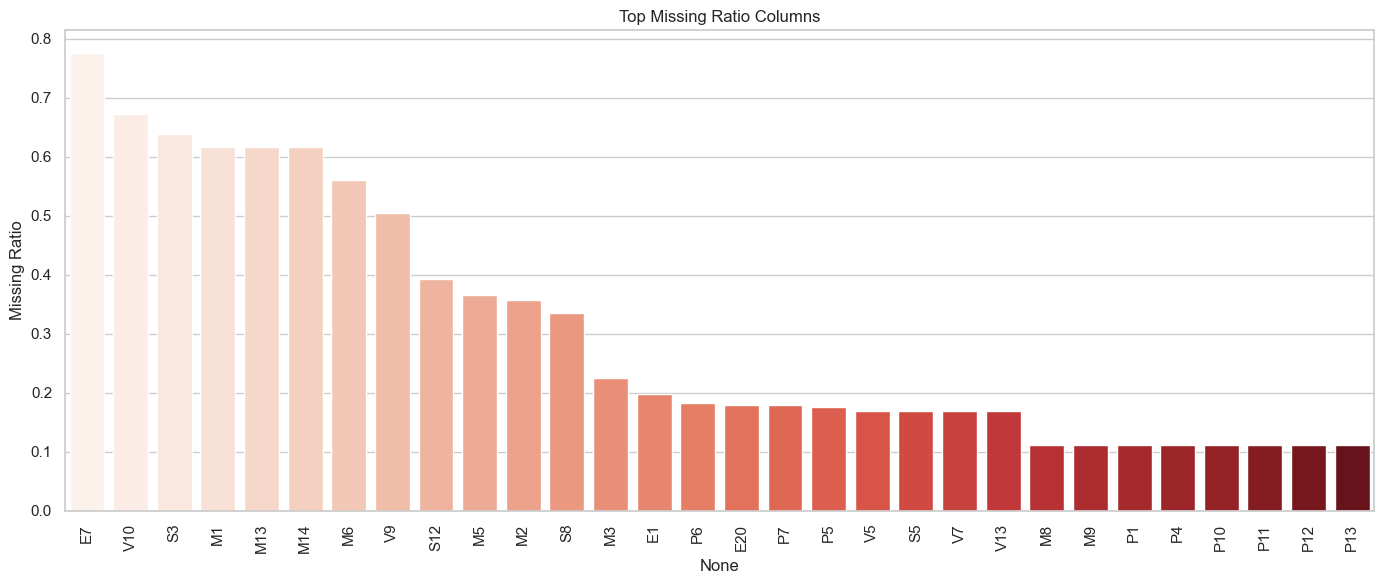

[INFO] Duplicate rows: 0
[INFO] Constant columns: 0 -> []


In [5]:

missing_ratio = train_df.isna().mean().sort_values(ascending=False)
display(missing_ratio.head(20).to_frame("missing_ratio"))

top_missing = missing_ratio.head(30)
plt.figure(figsize=(14, 6))
sns.barplot(x=top_missing.index, y=top_missing.values, palette="Reds")
plt.xticks(rotation=90)
plt.title("Top Missing Ratio Columns")
plt.ylabel("Missing Ratio")
plt.tight_layout()
plt.show()

duplicate_rows = train_df.duplicated().sum()
constant_cols = [c for c in train_df.columns if train_df[c].nunique(dropna=False) <= 1]
print(f"[INFO] Duplicate rows: {duplicate_rows}")
print(f"[INFO] Constant columns: {len(constant_cols)} -> {constant_cols[:20]}")


### 3. 相关性分析
- 计算数值特征之间的相关系数矩阵
- 针对目标列挑选相关性最高的特征，并对前 25 个特征绘制热力图

,corr_with_target
forward_returns,1.000000
market_forward_excess_returns,0.999957
M4,-0.066591
V13,0.063071
M1,0.044979
S5,0.040562
S2,-0.037465
D2,0.034180
D1,0.034180
M2,0.033464


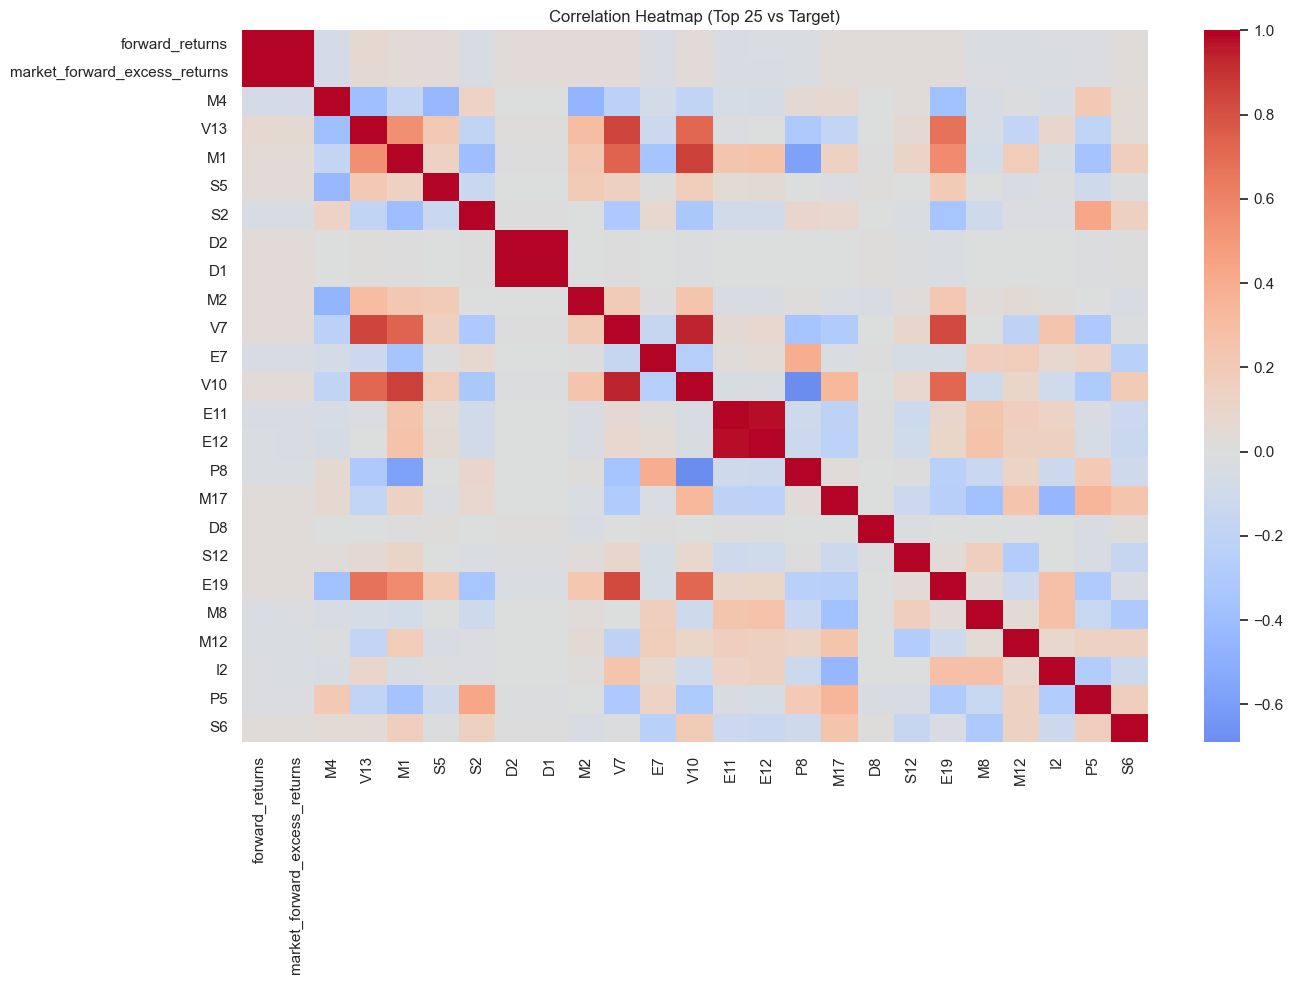

In [6]:

numeric_cols = eda_df.select_dtypes(include=[np.number]).columns.tolist()
if TARGET_COL not in numeric_cols:
    raise ValueError(f"Target column {TARGET_COL} not numeric or missing.")

corr_matrix = eda_df[numeric_cols].corr()
target_corr = corr_matrix[TARGET_COL].dropna().sort_values(key=lambda s: -s.abs())
display(target_corr.head(30).to_frame("corr_with_target"))

top_feats = target_corr.head(25).index.tolist()
plt.figure(figsize=(14, 10))
sns.heatmap(corr_matrix.loc[top_feats, top_feats], cmap="coolwarm", center=0, annot=False)
plt.title("Correlation Heatmap (Top 25 vs Target)")
plt.tight_layout()
plt.show()


### 4. PCA（主成分分析）
- 标准化数值特征（排除目标列）
- 查看解释方差和累计贡献
- 展示前几个主成分的高载荷特征

,component,variance_ratio,cumulative
0,PC1,0.125238,0.125238
1,PC2,0.087499,0.212737
2,PC3,0.078831,0.291568
3,PC4,0.067216,0.358784
4,PC5,0.056001,0.414785
5,PC6,0.041885,0.456670
6,PC7,0.036966,0.493636
7,PC8,0.032458,0.526094
8,PC9,0.028014,0.554108
9,PC10,0.024743,0.578852


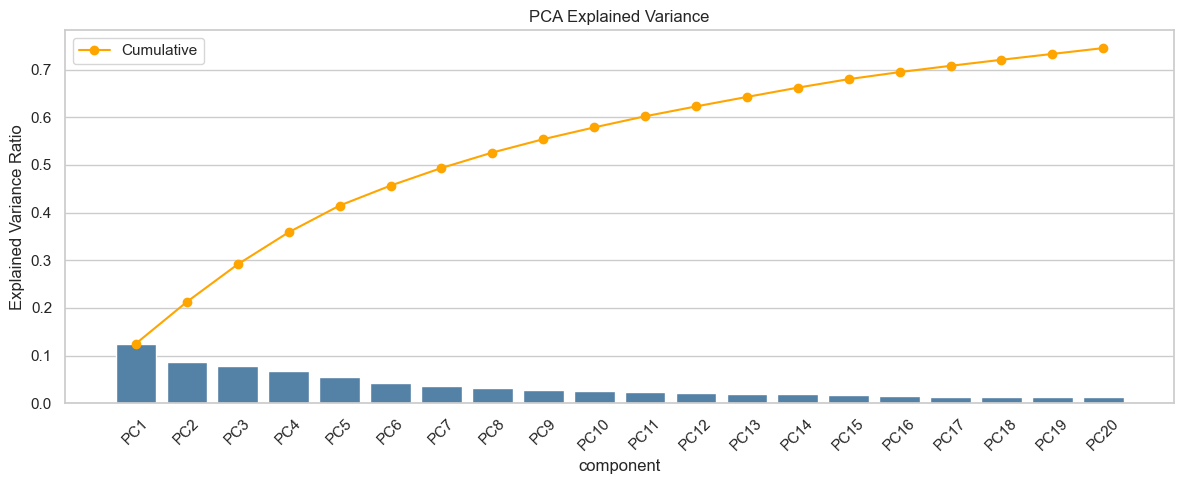


[INFO] PC1 top contributors:


,PC1
P10,0.228264
P8,0.218427
P11,0.216293
V11,0.187744
M13,0.180543
E2,0.175817
date_id,0.174326
M16,0.172444
M1,0.171208
M14,0.167911



[INFO] PC2 top contributors:


,PC2
date_id,0.219762
S4,0.204821
M18,0.204036
S10,0.201557
S11,0.199863
risk_free_rate,0.196380
M8,0.194050
E3,0.191746
V1,0.174020
S9,0.172432



[INFO] PC3 top contributors:


,PC3
P9,0.257187
E15,0.250346
I8,0.243720
M17,0.243459
I4,0.220716
I7,0.213114
P1,0.194429
M16,0.190183
M12,0.183387
S6,0.182413



[INFO] PC4 top contributors:


,PC4
V7,0.248049
E6,0.241064
E19,0.212671
V13,0.207489
S7,0.200203
I1,0.198973
E10,0.197911
E5,0.193799
I3,0.179101
I7,0.150896



[INFO] PC5 top contributors:


,PC5
M11,0.249109
E11,0.245948
E12,0.244829
V2,0.235358
P1,0.232032
V4,0.225323
V3,0.217228
M9,0.209533
E10,0.209079
I6,0.199141


In [7]:
feature_cols = [c for c in numeric_cols if c != TARGET_COL]
pca_df = eda_df[feature_cols].fillna(0.0)

scaler = StandardScaler()
scaled = scaler.fit_transform(pca_df)
n_components = min(20, scaled.shape[1])
pca = PCA(n_components=n_components, random_state=42)
components = pca.fit_transform(scaled)

explained = pd.DataFrame({
    "component": [f"PC{i+1}" for i in range(n_components)],
    "variance_ratio": pca.explained_variance_ratio_,
})
explained["cumulative"] = explained["variance_ratio"].cumsum()
display(explained.head(10))

plt.figure(figsize=(12, 5))
sns.barplot(x="component", y="variance_ratio", data=explained, color="steelblue")
plt.plot(explained.index, explained["cumulative"], marker="o", color="orange", label="Cumulative")
plt.xticks(rotation=45)
plt.ylabel("Explained Variance Ratio")
plt.title("PCA Explained Variance")
plt.legend()
plt.tight_layout()
plt.show()

loadings = pd.DataFrame(pca.components_.T, index=feature_cols, columns=explained["component"])
for comp in loadings.columns[:5]:
    top_loadings = loadings[comp].abs().sort_values(ascending=False).head(10)
    print(f"\n[INFO] {comp} top contributors:")
    display(top_loadings.to_frame(comp))


### 5. 关键特征筛选
结合目标相关性和 PCA 前 5 个主成分载荷的归一化分数，输出综合排名。

In [8]:

corr_score = target_corr.reindex(feature_cols).abs().fillna(0.0)
corr_norm = corr_score / (corr_score.max() or 1.0)

leading = loadings.iloc[:, :min(5, loadings.shape[1])].abs().sum(axis=1)
loading_norm = leading / (leading.max() or 1.0)

combined = 0.6 * corr_norm + 0.4 * loading_norm
ranking = (
    pd.DataFrame({
        "feature": feature_cols,
        "corr_score": corr_norm.values,
        "pca_score": loading_norm.values,
        "combined_score": combined.values,
    })
    .sort_values("combined_score", ascending=False)
    .head(40)
)
display(ranking.head(20))


,feature,corr_score,pca_score,combined_score
96,market_forward_excess_returns,1.000000,0.030593,0.612237
21,E2,0.000533,1.000000,0.400320
48,M18,0.012796,0.952962,0.388862
62,P2,0.001747,0.949777,0.380959
92,V7,0.032737,0.894888,0.377598
23,E3,0.000025,0.943646,0.377473
82,V1,0.003888,0.906916,0.365100
30,I1,0.005367,0.894605,0.361063
41,M11,0.006996,0.878781,0.355710
94,V9,0.016584,0.832668,0.343018


### 6. 小结
- 上述分析提供了缺失分布、变量相关性、PCA 解释方差以及关键特征排名。
- 可根据关键特征列表进一步优化 TabPFN 模型或用于特征选择。